# Geospatial research


In [ ]:
%pip install geopandas
%pip install geopy
%pip install matplotlib

In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, LineString

# Sample events dataframe (flatten your JSON into pandas DataFrame)
data = {
    'id': [1, 2],
    'title': ["Padua Food & Drink Event #1", "San Donà di Piave Arts & Crafts Event #2"],
    'latitude': [45.4077172, 45.6294811],
    'longitude': [11.8734455, 12.5641057],
    # add other fields as needed
}

df = pd.DataFrame(data)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude))
gdf.set_crs(epsg=4326, inplace=True)  # WGS84 lat/lon

# Suppose you have a route as a LineString between Vicenza and Padua
route_coords = [(11.546699, 45.545932), (11.8734455, 45.4077172)]  # (lon, lat) tuples
route_line = LineString(route_coords)
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326")

# Reproject to metric CRS for buffering (meters)
gdf_m = gdf.to_crs(epsg=3857)
route_m = route_gdf.to_crs(epsg=3857)

# Create 1 km buffer around route
buffer = route_m.buffer(1000).iloc[0]

# Filter events within buffer polygon
events_in_buffer = gdf_m[gdf_m.geometry.within(buffer)]

# Convert filtered events back to lat/lon CRS for display
events_in_buffer_wgs = events_in_buffer.to_crs(epsg=4326)

print(events_in_buffer_wgs[['id', 'title', 'geometry']])


   id                        title                   geometry
0   1  Padua Food & Drink Event #1  POINT (11.87345 45.40772)


/tmp/ipykernel_29177/1274075854.py:23: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


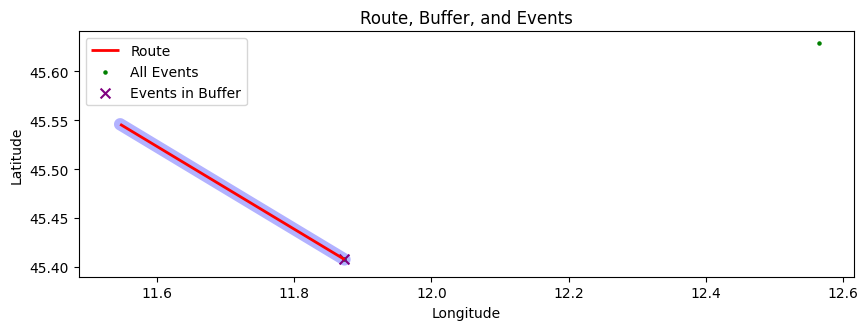

In [3]:
import matplotlib.pyplot as plt

# Plot the route and the buffer
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (converted back to WGS84 for plotting with events)
route_gdf.to_crs(epsg=4326).plot(ax=ax, color='red', linewidth=2, label='Route')

# Plot the buffer (converted back to WGS84 for plotting with events)
buffer_wgs = gpd.GeoSeries([buffer], crs=3857).to_crs(epsg=4326)
buffer_wgs.plot(ax=ax, color='blue', alpha=0.3, label='1km Buffer')

# Plot the events
gdf.to_crs(epsg=4326).plot(ax=ax, color='green', marker='o', markersize=5, label='All Events')

# Plot events within the buffer
events_in_buffer_wgs.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events in Buffer')


ax.set_title("Route, Buffer, and Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

### Query to qdrant of a route

In [5]:
import numpy as np
from shapely.geometry import LineString
from qdrant_client import QdrantClient
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance

load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)

# 1. Define your route (lon, lat)
#route_coords = [(11.546699, 45.545932), (11.8834455, 45.4077172)]
route_coords = [
    #(11.546698, 45.545932),     # Vicenza
    #(11.6603917, 45.2254915),   # Este
    (11.8734458, 45.4077173),   # Padua
    (12.84052, 45.78071)        # Portogruaro
]



route_line = LineString(route_coords)

# 2. Buffer the route by 1km (1000 meters)
# Convert to a projected CRS for accurate buffering
route_gdf = gpd.GeoSeries([route_line], crs="EPSG:4326").to_crs(epsg=3857)
buffer_poly = route_gdf.buffer(1000).to_crs(epsg=4326).iloc[0]  # back to WGS84

# 3. Get polygon coordinates for Qdrant (as [lon, lat] lists)
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()

# 4. Convert polygon coords to [{"lon": lon, "lat": lat}, ...] format for Qdrant
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]
# 5. Connect to Qdrant

# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior


from qdrant_client.http import models as qmodels

#startinputdate = "2025-08-23T10:04:00Z"
#endinputdate = "2025-08-23T10:19:00Z"

startinputdate = "2025-08-29T08:54:00Z"
endinputdate = "2025-09-29T09:56:00Z"



geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# Date filters for start_date and end_date inside input range
start_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        

# Date filters for start_date and end_date inside input range
end_date_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
            gte=startinputdate,
            lte=endinputdate,
            )
        )
    ]
)        



# Combine date filters with OR
date_filter = qmodels.Filter(
    should=[
        start_date_filter,
        end_date_filter
    ],
    #min_should_match=1
)

date_intersection_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="start_date",
            range=qmodels.DatetimeRange(
                lte=endinputdate
            )
        ),
        qmodels.FieldCondition(
            key="end_date",
            range=qmodels.DatetimeRange(
                gte=startinputdate
            )
        )
    ]
)

# Final combined filter: must be inside geo polygon AND start_date OR end_date in range
final_filter = qmodels.Filter(
    must=[
        geo_filter,
        date_intersection_filter #date_filter
    ]
)



# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=final_filter,#start_date_filter,#geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd



#print(f"polygon con buffer",polygon_coords_qdrant)

# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



id                                 title       category  \
0    85                 Mirano Tour Event #85           Tour   
1   352          Portogruaro Sport Event #352          Sport   
2    55           Portogruaro Music Event #55          Music   
3   111           Padua Exhibition Event #111     Exhibition   
4   257            Mirano Workshop Event #257       Workshop   
5    36           Portogruaro Sport Event #36          Sport   
6    91              Padua Festival Event #91       Festival   
7   265       Portogruaro Festival Event #265       Festival   
8   231             Padua Workshop Event #231       Workshop   
9   245  Portogruaro Arts & Crafts Event #245  Arts & Crafts   
10  442          Mirano Exhibition Event #442     Exhibition   
11  126             Padua Workshop Event #126       Workshop   
12  429               Mirano Music Event #429          Music   
13  145          Mirano Exhibition Event #145     Exhibition   
14  359               Mirano Sport Event #359          Sport   
15  148        Mirano Food & Drink Event #148   Food & Drink   
16  340          Mirano Conference Event #340     Conference   
17   32      Portogruaro Exhibition Event #32     Exhibition   
18  198                Padua Sport Event #198          Sport   
19   37              Padua Festival Event #37       Festival   
20  115     Portogruaro Exhibition Event #115     Exhibition   
21   84           Portogruaro Music Event #84          Music   
22  307                 Padua Tour Event #307           Tour   
23  361             Mirano Theatre Event #361        Theatre   
24  353       Portogruaro Festival Event #353       Festival   

                                          description         city  \
0   Seeking adventure in Mirano? Look no further t...       Mirano   
1   Explore the vibrant sport scene in Portogruaro...  Portogruaro   
2   Seeking adventure in Portogruaro? Look no furt...  Portogruaro   
3   Immerse yourself in the rich culture of Padua ...        Padua   
4   Immerse yourself in the rich culture of Mirano...       Mirano   
5   Expand your horizons with this insightful spor...  Portogruaro   
6   Explore the vibrant festival scene in Padua wi...        Padua   
7   A unique festival opportunity awaits you in Po...  Portogruaro   
8   Prepare for an unforgettable workshop experien...        Padua   
9   Prepare for an unforgettable arts & crafts exp...  Portogruaro   
10  Unwind and enjoy a delightful exhibition exper...       Mirano   
11  Explore the vibrant workshop scene in Padua wi...        Padua   
12  Connect with fellow enthusiasts at this lively...       Mirano   
13  Seeking adventure in Mirano? Look no further t...       Mirano   
14  Seeking adventure in Mirano? Look no further t...       Mirano   
15  Explore the vibrant food & drink scene in Mira...       Mirano   
16  Unwind and enjoy a delightful conference exper...       Mirano   
17  Explore the vibrant exhibition scene in Portog...  Portogruaro   
18  Connect with fellow enthusiasts at this lively...        Padua   
19  Expand your horizons with this insightful fest...        Padua   
20  Step into a world of wonder at this extraordin...  Portogruaro   
21  Connect with fellow enthusiasts at this lively...  Portogruaro   
22  Immerse yourself in the rich culture of Padua ...        Padua   
23  Dive into the world of theatre at this excitin...       Mirano   
24  Prepare for an unforgettable festival experien...  Portogruaro   

              start_date              end_date  \
0   2025-09-27T17:01:00Z  2025-09-27T23:01:00Z   
1   2025-09-28T07:11:00Z  2025-09-28T12:11:00Z   
2   2025-09-18T00:47:00Z  2025-09-18T09:47:00Z   
3   2025-09-26T19:57:00Z  2025-09-27T04:57:00Z   
4   2025-09-10T04:29:00Z  2025-09-10T07:29:00Z   
5   2025-09-13T05:44:00Z  2025-09-13T11:44:00Z   
6   2025-09-27T17:08:00Z  2025-09-28T01:08:00Z   
7   2025-09-23T06:04:00Z  2025-09-23T08:04:00Z   
8   2025-09-27T22:16:00Z  2025-09-28T00:16:00Z   
9   2025-09-22T14:3

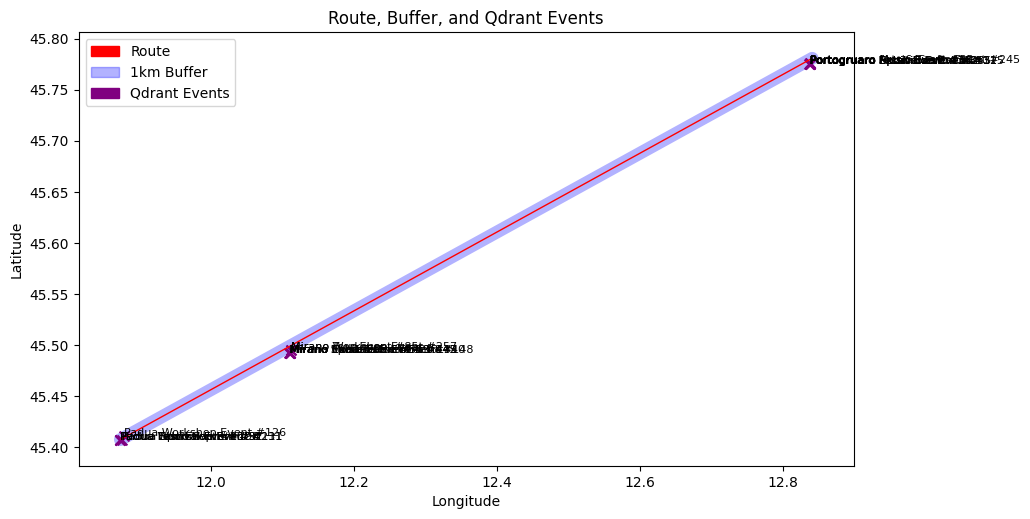

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.patches as mpatches

# Collect Qdrant results into a GeoDataFrame
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# Plot the route (no label here)
gpd.GeoSeries([route_line], crs="EPSG:4326").plot(ax=ax, color='red', linewidth=1)

# Plot the buffer (no label here)
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3)

# Plot Qdrant events
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50)
    # Optionally, add event titles
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

# Manually create legend patches
route_patch = mpatches.Patch(color='red', label='Route')
buffer_patch = mpatches.Patch(color='blue', alpha=0.3, label='1km Buffer')
events_patch = mpatches.Patch(color='purple', label='Qdrant Events')
ax.legend(handles=[route_patch, buffer_patch, events_patch])

ax.set_title("Route, Buffer, and Qdrant Events")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

## I want to use Openstreetmap to create a real route

In [ ]:
%pip install osmnx

MultiDiGraph with 9944 nodes and 21419 edges
stampato G
325074361 9416572746
[325074361, 5001672068, 10819852393, 12559101771, 618643804, 618643777, 330196737, 330196268, 247911074, 1459121943, 330195233, 247906863, 330198013, 194420355, 254931559, 254931563, 254931550, 1544008135, 254931535, 254931536, 10315488615, 254931539, 254931542, 254931518, 517735773, 518014388, 517735726, 517735874, 517735554, 6697056271, 485924926, 243517142, 2310870131, 243517135, 256071918, 1834754045, 207094142, 7049685181, 255896874, 256071993, 256072058, 256072265, 762596339, 1132461607, 207093931, 521993247, 249442832, 249442864, 207096137, 210472874, 207094123, 12032040918, 465624031, 482256329, 482256334, 482256321, 729308457, 207096139, 2517681265, 263675896, 263675895, 729308463, 689585569, 729308491, 11252603899, 729308444, 729308551, 729308415, 729308494, 762106941, 677697786, 471611082, 729308468, 729308516, 729308545, 761251612, 687518445, 687518477, 260772863, 419383882, 415488489, 3936675385, 

<Axes: >

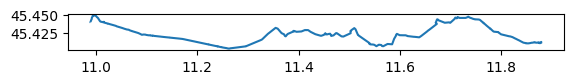

In [7]:
import osmnx as ox
from shapely.geometry import Polygon, LineString
import geopandas as gpd
import geopandas as gpd
import numpy as np
ox.settings.use_cache = True  # enable caching of HTTP requests

# Your origin and destination points (lat, lon) like (y,x)
#origin_point = (45.640317186277066, 12.241487413188237) # strada Terraglio TV
#destination_point = (45.68758465370057, 12.2562502911396) # prima di Selvana TV


origin_point = (45.41026004774276, 11.877749172855356) # Padova
destination_point = (45.44013878631641, 10.989916584327693) # Verona
#origin_point = (45.4109553303283, 11.883520063045811) # Padova (PD)
#destination_point = (45.55564536495325, 11.543093946961582) # Vicenza (VI)

#destination_point = (45.45795667928977, 10.982370142567046) # Verona (VR)
#origin_point = (45.5063774869007, 10.73446566988937) # Lazise (VR)
#destination_point =(45.43848433719987, 10.969985064989903) # Verona (VR)

# Create bounding box polygon covering both points
min_lat = min(origin_point[0], destination_point[0])
max_lat = max(origin_point[0], destination_point[0])
min_lon = min(origin_point[1], destination_point[1])
max_lon = max(origin_point[1], destination_point[1])

bbox_polygon = Polygon([
    (min_lon, min_lat),  # southwest
    (min_lon, max_lat),  # northwest
    (max_lon, max_lat),  # northeast
    (max_lon, min_lat),  # southeast
    (min_lon, min_lat)   # close polygon
])

from shapely.geometry import Polygon
bbox_polygon = bbox_polygon.buffer(0.01)  # buffer about 1 km depending on coordinates

# Download drivable road network within this polygon
G = ox.graph_from_polygon(bbox_polygon, network_type='drive', retain_all=True)
print(G)
print("stampato G")
# Find nearest nodes to origin and destination points in graph (lon, lat)
origin_node = ox.distance.nearest_nodes(G, origin_point[1], origin_point[0],return_dist=False)
destination_node = ox.distance.nearest_nodes(G, destination_point[1], destination_point[0],return_dist=False)
print(origin_node,destination_node)
#origin_node=247910834
#destination_node=530212898

# Compute shortest path by length
#route = ox.shortest_path(G, origin_node, destination_node, weight='length')
route = ox.shortest_path(G, origin_node, destination_node, weight='length')
print(route)


# Extract node coordinates for route geometry
route_coords = [(G.nodes[n]['x'], G.nodes[n]['y']) for n in route]

# Create a LineString for the route
route_line = LineString(route_coords)

# Create GeoDataFrame for route
route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')

# Convert to projected CRS for buffering
route_gdf_3857 = route_gdf.to_crs(epsg=3857)
buffer_poly = route_gdf_3857.buffer(1000).to_crs(epsg=4326).iloc[0]

# Extract polygon coordinates for Qdrant filter
polygon_coords = np.array(buffer_poly.exterior.coords).tolist()
polygon_coords_qdrant = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

print(polygon_coords_qdrant)

# Plot the route
route_gdf.plot()


In [8]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

id                           title       category  \
0   10  Verona Arts & Crafts Event #10  Arts & Crafts   
1  111     Padua Exhibition Event #111     Exhibition   
2  208      Verona Workshop Event #208       Workshop   
3   91        Padua Festival Event #91       Festival   
4  231       Padua Workshop Event #231       Workshop   
5  126       Padua Workshop Event #126       Workshop   
6  198          Padua Sport Event #198          Sport   
7   37        Padua Festival Event #37       Festival   
8  307           Padua Tour Event #307           Tour   

                                         description    city  \
0  Immerse yourself in the rich culture of Verona...  Verona   
1  Immerse yourself in the rich culture of Padua ...   Padua   
2  Dive into the world of workshop at this exciti...  Verona   
3  Explore the vibrant festival scene in Padua wi...   Padua   
4  Prepare for an unforgettable workshop experien...   Padua   
5  Explore the vibrant workshop scene in Padua wi...   Padua   
6  Connect with fellow enthusiasts at this lively...   Padua   
7  Expand your horizons with this insightful fest...   Padua   
8  Immerse yourself in the rich culture of Padua ...   Padua   

             start_date              end_date  \
0  2025-09-18T03:23:00Z  2025-09-18T09:23:00Z   
1  2025-09-26T19:57:00Z  2025-09-27T04:57:00Z   
2  2025-08-31T17:02:00Z  2025-09-01T01:02:00Z   
3  2025-09-27T17:08:00Z  2025-09-28T01:08:00Z   
4  2025-09-27T22:16:00Z  2025-09-28T00:16:00Z   
5  2025-09-02T19:17:00Z  2025-09-02T23:17:00Z   
6  2025-09-09T20:27:00Z  2025-09-09T23:27:00Z   
7  2025-09-11T17:16:00Z  2025-09-12T01:16:00Z   
8  2025-09-22T14:39:00Z  2025-09-22T23:39:00Z   

                                     url  \
0   https://example.com/veneto-events/10   
1  https://example.com/veneto-events/111   
2  https://example.com/veneto-events/208   
3   https://example.com/veneto-events/91   
4  https://example.com/veneto-events/231   
5  https://example.com/veneto-events/126   
6  https://example.com/veneto-events/198   
7   https://example.com/veneto-events/37   
8  https://example.com/veneto-events/307   

                                                hash  \
0  1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...   
1  ec4b22948e65b96db7b4a06f780ea03252347c37768648...   
2  65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...   
3  7915ee163dd971efa6dab07dc161211734497c0e35b679...   
4  41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...   
5  2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...   
6  76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...   
7  d610fe687a16741994be38c52d9a5d738c5df039b516dc...   
8  f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...   

              location.venue                          location.address  \
0     Santa Anastasia Church    Santa Anastasia Church, Verona, Veneto   
1  Abbazia di Santa Giustina  Abbazia di Santa Giustina, Padua, Veneto   
2         Torre dei Lamberti        Torre dei Lamberti, Verona, Veneto   
3            Museo Antoniano            Museo Antoniano, Padua, Veneto   
4               Civic Museum               Civic Museum, Padua, Veneto   
5             Museo Bottacin             Museo Bottacin, Padua, Veneto   
6          Piazza delle Erbe          Piazza delle Erbe, Padua, Veneto   
7        Museo del Precinema        Museo del Precinema, Padua, Veneto   
8               Civic Museum               Civic Museum, Padua, Veneto   

   location.latitude  location.longitude  location.lat  location.lon  
0          45.438496           10.992412     45.438496     10.992412  
1          45.407717           11.873446     45.407717     11.873446  
2          45.438496           10.992412     45.438496     10.992412  
3          45.407717           11.873446     45.407717     11.873446  
4          45.407717           11.873446     45.407717     11.873446  
5          45.411432           11.878154     45.411432     11.878154  
6          45.406932           11.875273     45.406932     11

/tmp/ipykernel_29177/1829689547.py:37: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


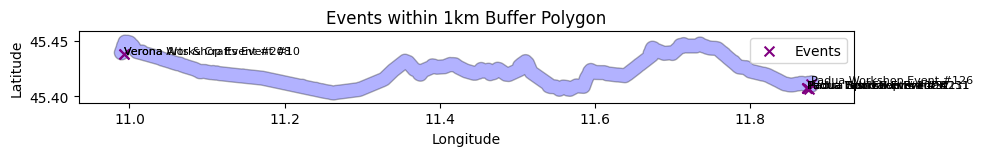

In [9]:
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

# Build gdf_qdrant from Qdrant results if not already defined
event_points = []
titles = []
for point in results.points:
    loc = point.payload.get("location", {})
    lat = loc.get("lat")
    lon = loc.get("lon")
    if lat is not None and lon is not None:
        event_points.append(Point(lon, lat))
        titles.append(point.payload.get("title", ""))

if event_points:
    gdf_qdrant = gpd.GeoDataFrame({"title": titles, "geometry": event_points}, crs="EPSG:4326")
else:
    gdf_qdrant = gpd.GeoDataFrame(columns=["title", "geometry"], crs="EPSG:4326")

fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buffer polygon
gpd.GeoSeries([buffer_poly], crs="EPSG:4326").plot(ax=ax, color='blue', alpha=0.3, edgecolor='black', label='1km Buffer')

# Plot the events inside the buffer
if not gdf_qdrant.empty:
    gdf_qdrant.plot(ax=ax, color='purple', marker='x', markersize=50, label='Events')
    for idx, row in gdf_qdrant.iterrows():
        ax.text(row.geometry.x, row.geometry.y, row.title, fontsize=8, color='black')
else:
    print("No events found in Qdrant for this buffer.")

ax.set_title("Events within 1km Buffer Polygon")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.legend()
plt.show()

In [ ]:
%pip install openrouteservice

In [10]:
import openrouteservice
from openrouteservice import convert
import os

from dotenv import load_dotenv

load_dotenv(dotenv_path="../.env")

OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")


# Specify your personal API key here
api_key = OPENROUTE_API_KEY

# Initialize the client with your API key
client = openrouteservice.Client(key=api_key)

# Define coordinates as a list of longitude, latitude tuples
coords = [(8.34234, 48.23424), (8.34423, 48.26424)]

# Request directions for cycling-regular profile
routes = client.directions(coords, profile='cycling-regular', optimize_waypoints=True)

# Print the raw response
print(routes)

# Decode the polyline geometry to GeoJSON format
geometry = routes['routes'][0]['geometry']
decoded = convert.decode_polyline(geometry)

# Print decoded geometry
print(decoded)


/home/biso/development/my_projects/.venv/lib/python3.12/site-packages/openrouteservice/directions.py:202: UserWarning: Less than 4 coordinates, nothing to optimize!
  warnings.warn("Less than 4 coordinates, nothing to optimize!", UserWarning)


{'bbox': [8.327725, 48.233135, 8.345244, 48.263552], 'routes': [{'summary': {'distance': 5205.9, 'duration': 1305.3}, 'segments': [{'distance': 5205.9, 'duration': 1305.3, 'steps': [{'distance': 888.7, 'duration': 234.8, 'type': 11, 'instruction': 'Head southwest', 'name': '-', 'way_points': [0, 24]}, {'distance': 822.8, 'duration': 164.6, 'type': 5, 'instruction': 'Turn slight right onto Sulzbacher Straße, K 5528', 'name': 'Sulzbacher Straße, K 5528', 'way_points': [24, 52]}, {'distance': 263.7, 'duration': 59.3, 'type': 1, 'instruction': 'Turn right', 'name': '-', 'way_points': [52, 61]}, {'distance': 301.9, 'duration': 67.9, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [61, 73]}, {'distance': 535.6, 'duration': 118.0, 'type': 0, 'instruction': 'Turn left', 'name': '-', 'way_points': [73, 84]}, {'distance': 248.1, 'duration': 55.8, 'type': 13, 'instruction': 'Keep right', 'name': '-', 'way_points': [84, 92]}, {'distance': 286.6, 'duration': 73.7, 'type': 1, 'inst

## I chose openroute services because it is reliable, fast, and ok with api limits

In [13]:
from qdrant_client.http import models as qmodels
import geopandas as gpd

import json
import os
from dotenv import load_dotenv
from qdrant_client import QdrantClient
from qdrant_client.http.models import PointStruct, VectorParams, Distance


load_dotenv(dotenv_path="../.env")

QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

client = QdrantClient(
    url=QDRANT_SERVER,
    api_key=QDRANT_API_KEY,
    timeout=2000000
)



# 6. Build geo filter for Qdrant using GeoLineString wrapper for exterior
geo_filter = qmodels.Filter(
    must=[
        qmodels.FieldCondition(
            key="location",  # or "geo" if that is your geo field name
            geo_polygon=qmodels.GeoPolygon(
                exterior=qmodels.GeoLineString(points=polygon_coords_qdrant)
            )
        )
    ]
)

# 7. Query Qdrant (returns points inside the polygon)
results = client.query_points(
    collection_name="veneto_events",
    limit=100,
    query_filter=geo_filter,   # your qmodels.Filter instance
    with_payload=True          # include full payload in results
)
#print(results)
# 8. Print results
import pandas as pd


print(polygon_coords_qdrant)
# Extract payloads from points
payloads = [point.payload for point in results.points]

# Create a DataFrame directly from the list of payload dictionaries
df = pd.json_normalize(payloads)  # This flattens nested dictionaries into columns

# Show the DataFrame
df



[{'lon': 10.982690964498163, 'lat': 45.446019957239905}, {'lon': 10.982708724873008, 'lat': 45.44620453816914}, {'lon': 10.982847288930863, 'lat': 45.44679683765832}, {'lon': 10.983065537414978, 'lat': 45.44737719706735}, {'lon': 10.983411637414978, 'lat': 45.44814687119577}, {'lon': 10.983678877661323, 'lat': 45.44866193701848}, {'lon': 10.984008901857294, 'lat': 45.44915875944199}, {'lon': 10.98479420120221, 'lat': 45.450218020715845}, {'lon': 10.984806168996679, 'lat': 45.45026183441387}, {'lon': 10.984973925748266, 'lat': 45.45076388390696}, {'lon': 10.98500182574827, 'lat': 45.450834281799985}, {'lon': 10.985372006673646, 'lat': 45.4515825183109}, {'lon': 10.985493006673646, 'lat': 45.45178500956397}, {'lon': 10.9858812214236, 'lat': 45.45235319681916}, {'lon': 10.986348378025367, 'lat': 45.452891343202644}, {'lon': 10.986889806269707, 'lat': 45.45339406974718}, {'lon': 10.987500093446654, 'lat': 45.45385635165833}, {'lon': 10.988173138456922, 'lat': 45.45427356850738}, {'lon': 10

id                           title       category  \
0   10  Verona Arts & Crafts Event #10  Arts & Crafts   
1  111     Padua Exhibition Event #111     Exhibition   
2  208      Verona Workshop Event #208       Workshop   
3   91        Padua Festival Event #91       Festival   
4  231       Padua Workshop Event #231       Workshop   
5  126       Padua Workshop Event #126       Workshop   
6  198          Padua Sport Event #198          Sport   
7   37        Padua Festival Event #37       Festival   
8  307           Padua Tour Event #307           Tour   

                                         description    city  \
0  Immerse yourself in the rich culture of Verona...  Verona   
1  Immerse yourself in the rich culture of Padua ...   Padua   
2  Dive into the world of workshop at this exciti...  Verona   
3  Explore the vibrant festival scene in Padua wi...   Padua   
4  Prepare for an unforgettable workshop experien...   Padua   
5  Explore the vibrant workshop scene in Padua wi...   Padua   
6  Connect with fellow enthusiasts at this lively...   Padua   
7  Expand your horizons with this insightful fest...   Padua   
8  Immerse yourself in the rich culture of Padua ...   Padua   

             start_date              end_date  \
0  2025-09-18T03:23:00Z  2025-09-18T09:23:00Z   
1  2025-09-26T19:57:00Z  2025-09-27T04:57:00Z   
2  2025-08-31T17:02:00Z  2025-09-01T01:02:00Z   
3  2025-09-27T17:08:00Z  2025-09-28T01:08:00Z   
4  2025-09-27T22:16:00Z  2025-09-28T00:16:00Z   
5  2025-09-02T19:17:00Z  2025-09-02T23:17:00Z   
6  2025-09-09T20:27:00Z  2025-09-09T23:27:00Z   
7  2025-09-11T17:16:00Z  2025-09-12T01:16:00Z   
8  2025-09-22T14:39:00Z  2025-09-22T23:39:00Z   

                                     url  \
0   https://example.com/veneto-events/10   
1  https://example.com/veneto-events/111   
2  https://example.com/veneto-events/208   
3   https://example.com/veneto-events/91   
4  https://example.com/veneto-events/231   
5  https://example.com/veneto-events/126   
6  https://example.com/veneto-events/198   
7   https://example.com/veneto-events/37   
8  https://example.com/veneto-events/307   

                                                hash  \
0  1fb3596c7adbbf0c7a1e155fa84b658a6898c1c1ba4984...   
1  ec4b22948e65b96db7b4a06f780ea03252347c37768648...   
2  65cf79d783d6a58e57c6a13a1da08e61fd32b91441c010...   
3  7915ee163dd971efa6dab07dc161211734497c0e35b679...   
4  41a0d445ff861968d063d2cd6c8d5324f38941f08b813e...   
5  2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...   
6  76d78442f73ada62b7820fec2e6d22b6cfcb28208a1a8e...   
7  d610fe687a16741994be38c52d9a5d738c5df039b516dc...   
8  f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...   

              location.venue                          location.address  \
0     Santa Anastasia Church    Santa Anastasia Church, Verona, Veneto   
1  Abbazia di Santa Giustina  Abbazia di Santa Giustina, Padua, Veneto   
2         Torre dei Lamberti        Torre dei Lamberti, Verona, Veneto   
3            Museo Antoniano            Museo Antoniano, Padua, Veneto   
4               Civic Museum               Civic Museum, Padua, Veneto   
5             Museo Bottacin             Museo Bottacin, Padua, Veneto   
6          Piazza delle Erbe          Piazza delle Erbe, Padua, Veneto   
7        Museo del Precinema        Museo del Precinema, Padua, Veneto   
8               Civic Museum               Civic Museum, Padua, Veneto   

   location.latitude  location.longitude  location.lat  location.lon  
0          45.438496           10.992412     45.438496     10.992412  
1          45.407717           11.873446     45.407717     11.873446  
2          45.438496           10.992412     45.438496     10.992412  
3          45.407717           11.873446     45.407717     11.873446  
4          45.407717           11.873446     45.407717     11.873446  
5          45.411432           11.878154     45.411432     11.878154  
6          45.406932           11.875273     45.406932     11

## Update 26/08/2025
## Now I query with prefecthes and filter


In [15]:
import pandas as pd
import openrouteservice
import re
from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models

load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")

# -------------------------
# Initialize clients
# -------------------------
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
COLLECTION_NAME = "veneto_events"

client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)

query_text = "Music"
origin_address= "Padova"
destination_address="Vicenza"
buffer_distance_km=3
start_date="2025-08-26T15:32:00Z"
end_date="2025-09-26T15:34:00Z"
# Embed query text to dense vector
query_dense_vector = list(dense_embedding_model.passage_embed([query_text]))[0].tolist()
# Embed query text to sparse vector
query_sparse_embedding = list(sparse_embedding_model.passage_embed([query_text]))[0]


#price_value = {}
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np
import openrouteservice
import qdrant_client.models as qmodels

# Assumes ors_client and qdrant_client are initialized outside this function

def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date):
    # Geocode address to (lon, lat)
    def geocode_address(address):
        geocode_result = ors_client.pelias_search(text=address)
        if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
            coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
            return tuple(coords)
        else:
            raise ValueError(f"Could not geocode address: {address}")

    # Get route points between origin and destination
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius
    routes = ors_client.directions(coordinates=coords, profile='driving-car', radiuses=radiuses, format='geojson')
    route_coords = routes['features'][0]['geometry']['coordinates']

    # Create route line and buffer polygon
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]

    # Prepare polygon coordinates for Qdrant geo filter (list of lon-lat dicts)
    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    # Build Qdrant filters
    geo_filter = qmodels.Filter(
        must=[
            qmodels.FieldCondition(
                key="location",
                geo_polygon=qmodels.GeoPolygon(
                    exterior=qmodels.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = qmodels.Filter(
        must=[
            qmodels.FieldCondition(
                key="start_date",
                range=qmodels.DatetimeRange(lte=end_date)
            ),
            qmodels.FieldCondition(
                key="end_date",
                range=qmodels.DatetimeRange(gte=start_date)
            )
        ]
    )

    # Combine filters into a final filter with must conditions
    final_filter = qmodels.Filter(
        must=geo_filter.must + date_filter.must
    )

    return final_filter

final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date)


# Perform hybrid query with prefetches for dense and sparse vectors using RRF fusion
results = client.query_points(
    collection_name=COLLECTION_NAME,
    prefetch=[
        models.Prefetch(
            query=models.SparseVector(
                indices=list(query_sparse_embedding.indices),
                values=list(query_sparse_embedding.values)
            ),
            using=sparse_vector_name,
            limit=50,
        ),
        models.Prefetch(
            query=query_dense_vector,
            using=dense_vector_name,
            limit=50,
        ),
    ],
    query=models.FusionQuery(fusion=models.Fusion.RRF),
    query_filter=final_filter,
    limit=10,
    with_payload=True,
)

# Process results into dataframe
records = []
for point in results.points:
    entry = dict(point.payload)
    entry["score"] = point.score
    records.append(entry)

df = pd.json_normalize(records)

# Reorder columns to put 'score' as second column if exists and price.value
cols = list(df.columns)
if "score" in cols:
    cols.remove("score")
    cols.insert(1, "score")
if "price.value" in cols:
    cols.remove("price.value")
    cols.remove("price_value")
    cols.insert(2, "price.value")
df = df[cols]

df


/tmp/ipykernel_29177/3028342300.py:25: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


id     score                          title    category  \
0  316  0.500000    Vicenza Festival Event #316    Festival   
1  109  0.333333    Vicenza Festival Event #109    Festival   
2   37  0.250000       Padua Festival Event #37    Festival   
3  455  0.200000        Vicenza Tour Event #455        Tour   
4  482  0.166667  Vicenza Conference Event #482  Conference   
5  307  0.142857          Padua Tour Event #307        Tour   
6  407  0.125000  Vicenza Conference Event #407  Conference   
7  126  0.111111      Padua Workshop Event #126    Workshop   
8  309  0.100000          Padua Tour Event #309        Tour   
9  260  0.090909  Vicenza Conference Event #260  Conference   

                                         description     city  \
0  Explore the vibrant festival scene in Vicenza ...  Vicenza   
1  Prepare for an unforgettable festival experien...  Vicenza   
2  Expand your horizons with this insightful fest...    Padua   
3  Prepare for an unforgettable tour experience i...  Vicenza   
4  Step into a world of wonder at this extraordin...  Vicenza   
5  Immerse yourself in the rich culture of Padua ...    Padua   
6  Explore the vibrant conference scene in Vicenz...  Vicenza   
7  Explore the vibrant workshop scene in Padua wi...    Padua   
8  Seeking adventure in Padua? Look no further th...    Padua   
9  Connect with fellow enthusiasts at this lively...  Vicenza   

             start_date              end_date  \
0  2025-09-15T15:46:00Z  2025-09-15T21:46:00Z   
1  2025-09-18T13:14:00Z  2025-09-18T16:14:00Z   
2  2025-09-11T17:16:00Z  2025-09-12T01:16:00Z   
3  2025-09-02T09:30:00Z  2025-09-02T19:30:00Z   
4  2025-09-07T20:23:00Z  2025-09-07T22:23:00Z   
5  2025-09-22T14:39:00Z  2025-09-22T23:39:00Z   
6  2025-08-31T09:21:00Z  2025-08-31T14:21:00Z   
7  2025-09-02T19:17:00Z  2025-09-02T23:17:00Z   
8  2025-09-25T18:30:00Z  2025-09-26T04:30:00Z   
9  2025-09-07T20:25:00Z  2025-09-07T23:25:00Z   

                                     url  \
0  https://example.com/veneto-events/316   
1  https://example.com/veneto-events/109   
2   https://example.com/veneto-events/37   
3  https://example.com/veneto-events/455   
4  https://example.com/veneto-events/482   
5  https://example.com/veneto-events/307   
6  https://example.com/veneto-events/407   
7  https://example.com/veneto-events/126   
8  https://example.com/veneto-events/309   
9  https://example.com/veneto-events/260   

                                                hash  \
0  380bf9531ebceeed8499f15c486d328927d53df32a3e5c...   
1  76bfee25773cd166bf6d33651ef5e0c4bf541c53388d09...   
2  d610fe687a16741994be38c52d9a5d738c5df039b516dc...   
3  52a13bbf6b77a8cbd79a9821ba0bca30994a9732ce322b...   
4  907f76f515f3061ac4bc044f84bb2deb21502f1188e71f...   
5  f8a0703b3a784c14006b22da06e67de50dd35a5fcfeb45...   
6  743a9b91e3ed189cda6c6ba78220901cd0101d227ae73f...   
7  2c2039eaf9d474957baca8bd38e51bcdc9d2721797c20d...   
8  2b729232e93b09899e838c3c1b15f16806f7ea21424350...   
9  86c60de4df87293a1ef5316083b650ae7eeb8013b136c4...   

                     location.venue  \
0                    Villa Trissino   
1           Villa Valmarana ai Nani   
2               Museo del Precinema   
3                     Palazzo Porto   
4                    Palazzo Thiene   
5                      Civic Museum   
6  Museo Naturalistico Archeologico   
7                    Museo Bottacin   
8                    Stadio Euganeo   
9                San Lorenzo Church   

                                    location.address  location.latitude  \
0                    Villa Trissino, Vicenza, Veneto          45.548831   
1           Villa Valmarana ai Nani, Vicenza, Veneto          45.548831   
2                 Museo del Precinema, Padua, Veneto          45.407717   
3                     Palazzo Porto, Vicenza, Veneto          45.548831   
4                    Palazzo Thiene, Vicenza, Veneto          45.548591   
5                        Civic Museum, Padua, Veneto          45.407717 

### Choosing the profile driving car or bike

In [2]:
import pandas as pd
import openrouteservice
import re
from qdrant_client.models import FieldCondition, Range, Filter
import os
from dotenv import load_dotenv
from fastembed import TextEmbedding, SparseTextEmbedding
from qdrant_client import QdrantClient, models
from shapely.geometry import LineString
import geopandas as gpd
import numpy as np


# Load environment variables
load_dotenv(dotenv_path="../.env")
OPENROUTE_API_KEY = os.getenv("OPENROUTE_API_KEY")
QDRANT_SERVER = os.getenv("QDRANT_SERVER")
QDRANT_API_KEY = os.getenv("QDRANT_API_KEY")

# Initialize OpenRouteService client
ors_client = openrouteservice.Client(key=OPENROUTE_API_KEY)

# Load embedding model names from env
DENSE_MODEL_NAME = os.getenv("DENSE_MODEL_NAME")   # e.g. "BAAI/bge-small-en-v1.5"
SPARSE_MODEL_NAME = os.getenv("SPARSE_MODEL_NAME") # e.g. "Qdrant/bm25"

if not QDRANT_SERVER or not QDRANT_API_KEY:
    raise ValueError("QDRANT_SERVER or QDRANT_API_KEY not defined in .env file")

# Initialize embedding clients
dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)
sparse_embedding_model = SparseTextEmbedding(SPARSE_MODEL_NAME)

dense_vector_name = "dense_vector"
sparse_vector_name = "sparse_vector"
COLLECTION_NAME = "veneto_events"

# Initialize Qdrant client
client = QdrantClient(url=QDRANT_SERVER, api_key=QDRANT_API_KEY, timeout=200000, https=False)


def create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile='driving-car'):
    # Geocode address to (lon, lat)
    def geocode_address(address):
        geocode_result = ors_client.pelias_search(text=address)
        if geocode_result and 'features' in geocode_result and len(geocode_result['features']) > 0:
            coords = geocode_result['features'][0]['geometry']['coordinates']  # [lon, lat]
            return tuple(coords)
        else:
            raise ValueError(f"Could not geocode address: {address}")

    # Get route points between origin and destination
    origin = geocode_address(origin_address)
    destination = geocode_address(destination_address)
    coords = [origin, destination]
    radiuses = [1000, 1000]  # buffering route ends roughly by 1 km radius
    routes = ors_client.directions(
        coordinates=coords,
        profile=profile,
        radiuses=radiuses,
        format='geojson'
    )
    route_coords = routes['features'][0]['geometry']['coordinates']

    # Create route line and buffer polygon
    route_line = LineString(route_coords)
    route_gdf = gpd.GeoDataFrame([{'geometry': route_line}], crs='EPSG:4326')
    route_gdf_3857 = route_gdf.to_crs(epsg=3857)  # project to meters
    buffer_polygon = route_gdf_3857.buffer(buffer_distance_km * 1000).to_crs(epsg=4326).iloc[0]

    # Prepare polygon coordinates for Qdrant geo filter (list of lon-lat dicts)
    polygon_coords = np.array(buffer_polygon.exterior.coords).tolist()
    qdrant_polygon_coords = [{"lon": lon, "lat": lat} for lon, lat in polygon_coords]

    # Build Qdrant filters
    geo_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="location",
                geo_polygon=models.GeoPolygon(
                    exterior=models.GeoLineString(points=qdrant_polygon_coords)
                )
            )
        ]
    )
    date_filter = models.Filter(
        must=[
            models.FieldCondition(
                key="start_date",
                range=models.DatetimeRange(lte=end_date)
            ),
            models.FieldCondition(
                key="end_date",
                range=models.DatetimeRange(gte=start_date)
            )
        ]
    )

    # Combine filters into a final filter with must conditions
    final_filter = models.Filter(
        must=geo_filter.must + date_filter.must
    )

    return final_filter




/tmp/ipykernel_30940/2766075774.py:31: UserWarning: The model sentence-transformers/paraphrase-multilingual-mpnet-base-v2 now uses mean pooling instead of CLS embedding. In order to preserve the previous behaviour, consider either pinning fastembed version to 0.5.1 or using `add_custom_model` functionality.
  dense_embedding_model = TextEmbedding(DENSE_MODEL_NAME)


In [3]:
# Parameters (can be adjusted dynamically)
query_text = "drink music"
origin_address = "Padova"
destination_address = "Chioggia"
buffer_distance_km = 5
start_date = "2025-08-26T15:32:00Z"
end_date = "2025-09-28T15:34:00Z"
profile_choice = 'driving-car'  # 'driving-car' or 'cycling-regular', 'foot-walking', etc.

score_treshold = 0.0
if query_text.strip() == "":
    score_treshold = 0.0  # No text query, so no score threshold
else:
    score_treshold = 0.34  # Adjust based on desired relevance
# Embed query text to dense vector
query_dense_vector = list(dense_embedding_model.passage_embed([query_text]))[0].tolist()
# Embed query text to sparse vector
query_sparse_embedding = list(sparse_embedding_model.passage_embed([query_text]))[0]

# Create filter with route buffer and date, using chosen profile
final_filter = create_route_buffer_filter(origin_address, destination_address, buffer_distance_km, start_date, end_date, profile=profile_choice)

# Perform hybrid query with prefetches for dense and sparse vectors using RRF fusion
results = client.query_points(
    collection_name=COLLECTION_NAME,
    prefetch=[
        models.Prefetch(
            query=models.SparseVector(
                indices=list(query_sparse_embedding.indices),
                values=list(query_sparse_embedding.values)
            ),
            using=sparse_vector_name,
            limit=50,
            #score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
        models.Prefetch(
            query=query_dense_vector,
            using=dense_vector_name,
            limit=50,
            score_threshold=score_treshold,  # Optional: filter out low-score results
        ),
    ],
    query=models.FusionQuery(fusion=models.Fusion.RRF),
    query_filter=final_filter,
    limit=100,
    with_payload=True,
    #score_threshold=score_treshold,  # Optional: filter out low-score results
)

# Process results into dataframe
records = []
for point in results.points:
    entry = dict(point.payload)
    entry["score"] = point.score
    records.append(entry)

df = pd.json_normalize(records)

# Reorder columns to put 'score' as second column if exists and price.value
cols = list(df.columns)
if "score" in cols:
    cols.remove("score")
    cols.insert(1, "score")
df = df[cols]

df


id     score                             title      category  \
0  283  0.833333         Chioggia Music Event #283         Music   
1  138  0.583333        Monselice Music Event #138         Music   
2  176  0.500000  Chioggia Food & Drink Event #176  Food & Drink   
3  356  0.400000         Chioggia Music Event #356         Music   
4  338  0.375000         Chioggia Music Event #338         Music   
5   47  0.333333          Chioggia Music Event #47         Music   
6   96  0.142857  Monselice Food & Drink Event #96  Food & Drink   

                                         description       city  \
0  Unwind and enjoy a delightful music experience...   Chioggia   
1  Dive into the world of music at this exciting ...  Monselice   
2  Seeking adventure in Chioggia? Look no further...   Chioggia   
3  Immerse yourself in the rich culture of Chiogg...   Chioggia   
4  Connect with fellow enthusiasts at this lively...   Chioggia   
5  Step into a world of wonder at this extraordin...   Chioggia   
6  Connect with fellow enthusiasts at this lively...  Monselice   

             start_date              end_date  \
0  2025-09-25T10:00:00Z  2025-09-25T12:00:00Z   
1  2025-09-27T20:56:00Z  2025-09-27T21:56:00Z   
2  2025-09-02T12:29:00Z  2025-09-02T21:29:00Z   
3  2025-09-12T14:43:00Z  2025-09-12T18:43:00Z   
4  2025-09-06T00:59:00Z  2025-09-06T07:59:00Z   
5  2025-08-30T07:27:00Z  2025-08-30T08:27:00Z   
6  2025-09-16T12:36:00Z  2025-09-16T17:36:00Z   

                                     url  \
0  https://example.com/veneto-events/283   
1  https://example.com/veneto-events/138   
2  https://example.com/veneto-events/176   
3  https://example.com/veneto-events/356   
4  https://example.com/veneto-events/338   
5   https://example.com/veneto-events/47   
6   https://example.com/veneto-events/96   

                                                hash  \
0  4679e1e7f197159ddbbb55a914cd312e387737bb8217fc...   
1  db28d3b47c83440056299318b9336465a6ff2221dc3b4d...   
2  34b3dc163d3a2f504498bbb341a77fb6194bd0491bcff5...   
3  033790c694cee3def6368dfcf4399906d327d2a5556d28...   
4  87d29311e8bd6b5c04da67664ee0d94f43a3600f873b95...   
5  0b3c3979f9f833d2daae9dd0e82f2ba051894ac3eaf58a...   
6  c1a2d078c9eda6aed38715066255db7f866f9c25b44b7a...   

                      location.venue  \
0               Isola di Pellestrina   
1                Chiesa di San Paolo   
2                  Sottomarina Beach   
3             Chiesa di San Domenico   
4  Cattedrale di Santa Maria Assunta   
5  Cattedrale di Santa Maria Assunta   
6                        Villa Duodo   

                                    location.address  location.latitude  \
0             Isola di Pellestrina, Chioggia, Veneto          45.218894   
1             Chiesa di San Paolo, Monselice, Veneto          45.241768   
2                Sottomarina Beach, Chioggia, Veneto          45.218894   
3           Chiesa di San Domenico, Chioggia, Veneto          45.218894   
4  Cattedrale di Santa Maria Assunta, Chioggia, V...          45.218894   
5  Cattedrale di Santa Maria Assunta, Chioggia, V...          45.218894   
6                     Villa Duodo, Monselice, Veneto          45.241768   

   location.longitude  location.lat  location.lon  
0           12.278581     45.218894     12.278581  
1           11.750853     45.241768     11.750853  
2           12.278581     45.218894     12.278581  
3           12.278581     45.218894     12.278581  
4           12.278581     45.218894     12.278581  
5           12.278581     45.218894     12.278581  
6           11.750853     45.241768     11.750853